---
title: 'Spatial Fay-Herriot: Mexico'
author: "Paul May"
date: '2024-01-05'
output: html_document
---

In [1]:
# knitr::opts_chunk$set(echo = TRUE)

In this demonstration, we will fit a spatial Fay-Herriot (SFH) model using the Horvitz-Thompson estimates for the DESECON4 areas, using aggregated L4B values as covariates. The model can be written as

\begin{align}
\hat{\mu}_i &= \mu_i + \delta_i, \tag{1}\\
\mu_i &= (\alpha + \tilde{\alpha}_i) + x_i(\beta + \tilde{\beta_i})  \tag{2}
\end{align}

Variable \hat{\mu}_i is the direct estimate for management unit (MU) $i$, $\mu_i$ is the true area AGBD and $\delta_i \sim N(0, \hat{\sigma}^2)$ is the sampling error, assumed to be normally distributed with known variance. Covariate $x_i$ is the L4B aggregate and $\alpha_i, \beta_i$ are regression coefficients. The terms $\tilde{\alpha}_i$ and $\tilde{\beta}_i$ vary by MU, giving a spatially varying intercept and coefficient for the L4B covariate respectively. We assume a Besag York Mollié (BYM) model for both these terms:
\url{https://inla.r-inla-download.org/r-inla.org/doc/latent/bym2.pdf}
which is the combination of a neighbor-wise correlated process and an independent error term. By neighbor-wise correlated, it means that two regions adjacent to each other are more likely to be similar than otherwise. There are MANY other possible covariance structures to try...


Let's load the necessary libraries first.

NEHA COMMENTS/QUESTIONS: 

(1) How would this equation change if I were to have mode than one covariate? Would it be: 

\begin{align}
\mu_i &= (\alpha + \tilde{\alpha}_i) + x1_i(\beta1 + \tilde{\beta1_i})  + x2_i(\beta2 + \tilde{\beta2_i}) \tag{3}
\end{align}

If yes, then I think I've tried to test this below. 

(2) Should we not test whether we need "spatially varying" coefficients? Is there a step somewhere that can show me that spatially varying intercepts and coefficients are better than having a single estimate for all MUs?

In [2]:
############# OPEN A TERMINAL AND OPEN R, THEN RUN THE FOLLOWING COMMAND ###################

# install.packages("INLA",repos=c(getOption("repos"),INLA="https://inla.r-inla-download.org/R/stable"), dep=TRUE)
# packages <- c("terra","dplyr","spdep", "exactextractr", "sf","ggplot2","viridis")
# package.check <- lapply(packages, FUN = function(x) {
#     if (!require(x, character.only = TRUE)) {
#         install.packages(x, dependencies = TRUE)
#         library(x, character.only = TRUE, quietly=TRUE)
#     }
# })
# Sys.setenv("AWS_DEFAULT_REGION" = 'us-west-2')

In [3]:
suppressWarnings({
suppressMessages({
library(INLA)

library(sf)
library(terra)
library(dplyr)
library(spdep) # Not completely necessary, you'll see later
library(exactextractr) # Not necessary, but great for aggregating raster data.

library(ggplot2) # These two are just for plotting
library(viridis)
})
})

Now we load the management unit shapefiles and the plot data.

Reading layer `ecort08gw_DESECON4_DISS' from data source 
  `/projects/my-public-bucket/Data/NASA_CMS_2023/MEXICO/ecort08gw_DESECON4_DISS.gpkg' 
  using driver `GPKG'
Simple feature collection with 101 features and 14 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -118.366 ymin: 14.53399 xmax: -86.71074 ymax: 32.7174
Geodetic CRS:  WGS 84
Reading layer `infys_arbolado_2015_2020_agbd' from data source 
  `/projects/my-public-bucket/Data/NASA_CMS_2023/MEXICO/INFYS_Arbolado_2015_2020_AGBD.gpkg' 
  using driver `GPKG'
Simple feature collection with 9955 features and 7 fields
Geometry type: POINT
Dimension:     XY
Bounding box:  xmin: -116.8126 ymin: 14.58767 xmax: -86.76697 ymax: 32.542
Geodetic CRS:  Undefined geographic SRS
Reading layer `ecort08gw_DESECON4_DISS' from data source 
  `/projects/my-public-bucket/Data/NASA_CMS_2023/MEXICO/ecort08gw_DESECON4_DISS.gpkg' 
  using driver `GPKG'
Simple feature collection with 101 features and 14 fields
Geometry type: M

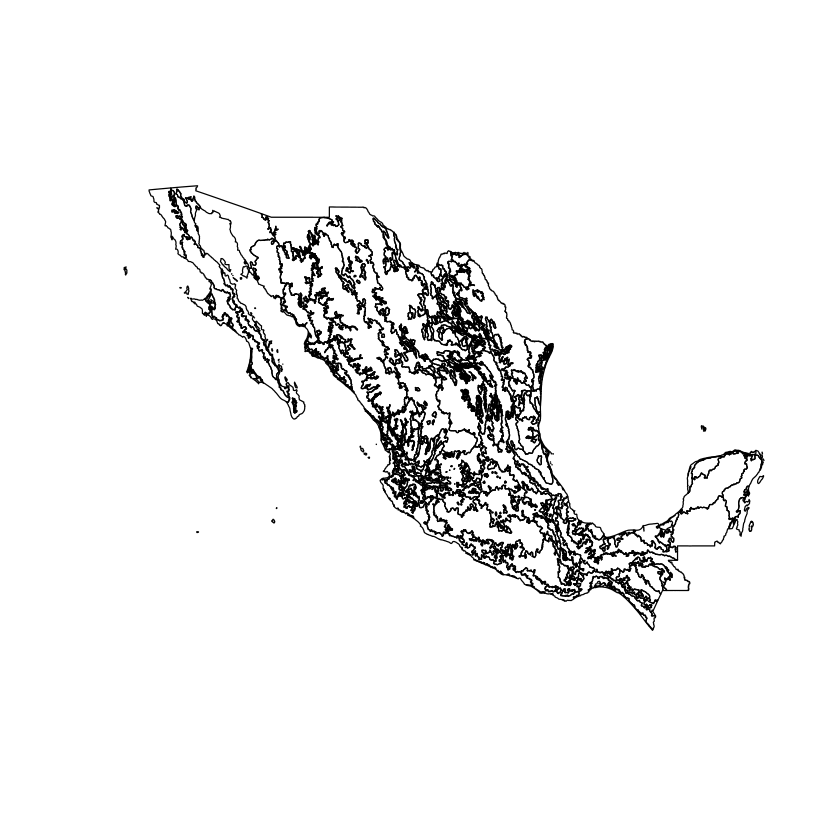

In [4]:
# Load management units
units.shp = st_read("/projects/my-public-bucket/Data/NASA_CMS_2023/MEXICO/ecort08gw_DESECON4_DISS.gpkg") %>%
  st_transform(6933) # Transformed into the native CRS of L4B
nu = nrow(units.shp)
plot(st_geometry(units.shp))
# Load plot data
plot = st_read("/projects/my-public-bucket/Data/NASA_CMS_2023/MEXICO/INFYS_Arbolado_2015_2020_AGBD.gpkg") %>%
  st_transform(6933)

# Saving also in orginal WGS84 coordiantes (because CCI maps are in WGS84) 
units_WGS84.shp = st_read("/projects/my-public-bucket/Data/NASA_CMS_2023/MEXICO/ecort08gw_DESECON4_DISS.gpkg")
plot_WGS84 = st_read("/projects/my-public-bucket/Data/NASA_CMS_2023/MEXICO/INFYS_Arbolado_2015_2020_AGBD.gpkg")

We'll use the L4B data as covariates:

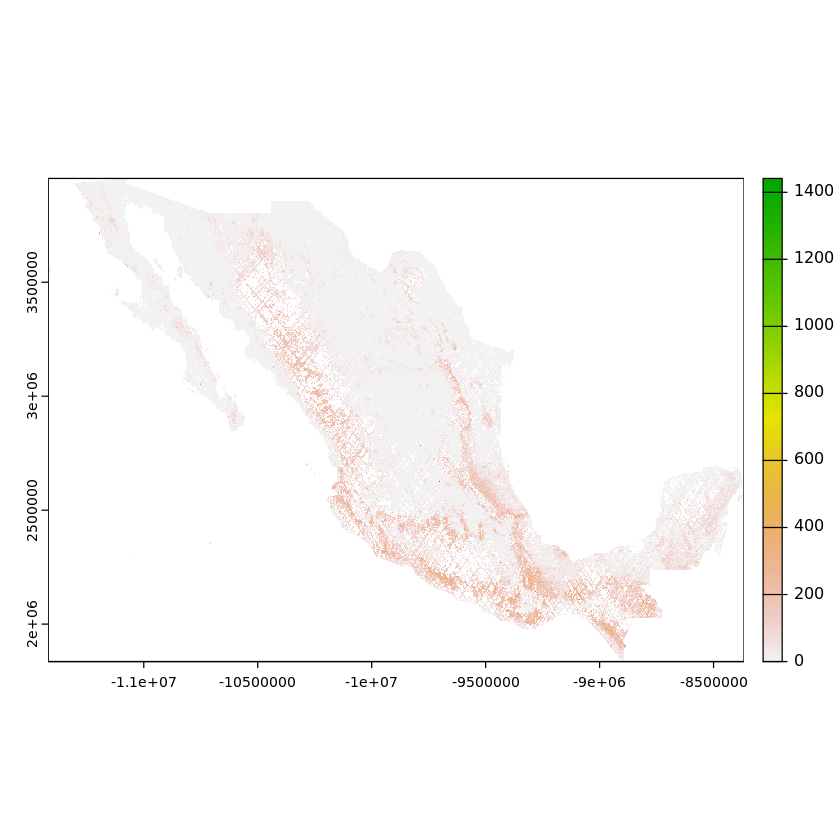

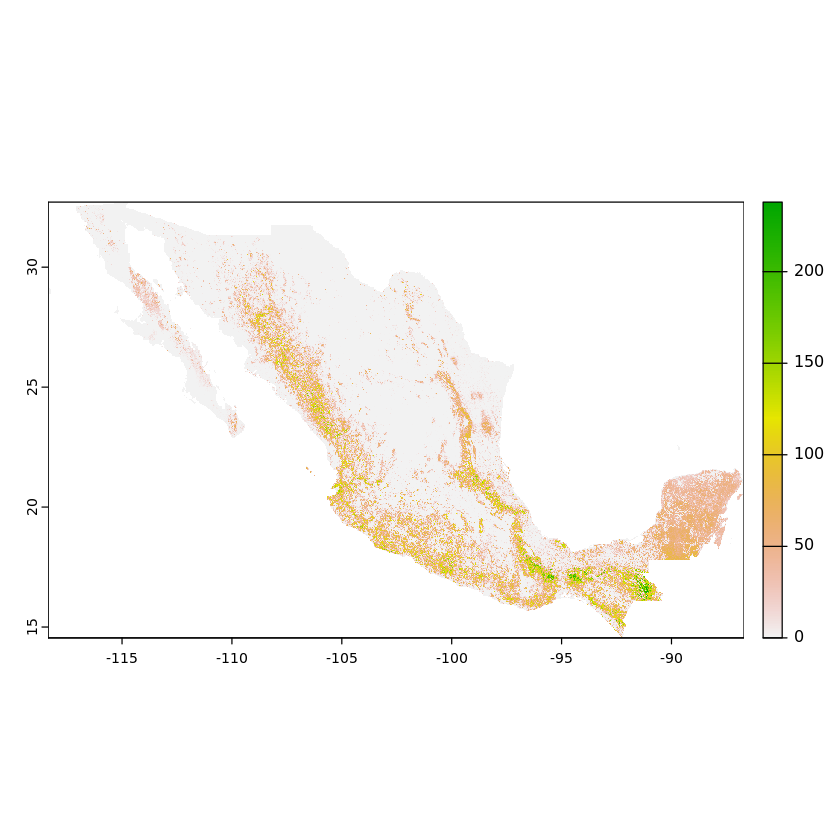

In [5]:
l4b = rast("/projects/my-public-bucket/Data/NASA_CMS_2023/MEXICO/l4b_mexico.tif") 
CCI = rast("/projects/my-public-bucket/Biomass_Harmonization_OUTPUTS/_PAPER1_OUTPUTS/MEX/MEX_Product_AOI/CCI_AOImasked.tif")
plot(l4b)
plot(CCI)

In [37]:
crs(l4b, describe=T)

name,authority,code,area,extent
<chr>,<chr>,<chr>,<chr>,<list>
WGS 84 / NSIDC EASE-Grid 2.0 Global,EPSG,6933,World between 86°S and 86°N,"-180, 180, 86, -86"


Now we will construct design-based estimates (where possible) for each of the MUs. We'll use a Horvitz-Thompson estimate assuming simple random sampling (though I do not know if that is true of these NFI plots. Looks like there are only 72 plots with an AGBD of zero. How is that possible? Are they measuring cacti and shrub?)

In [6]:
# Assign plots to units
p2u = st_contains(units.shp, plot)

# Get direct estimates and standard errors
direct = data.frame(mean = numeric(nu), sd = numeric(nu), nplots = integer(nu))

for(i in 1:nu){
  index = p2u[[i]] # Which plots are in this unit?
  if(length(index) >= 2){ # This is (mathematically) the minimum required to compute a design-based standard error.
    bio = plot$NFI_AGBD_flt[index]
    # Horvitz-Thompson estimates (assuming simple random sampling)
    direct$mean[i] = mean(bio)
    direct$sd[i] = sqrt(var(bio)/length(index))
    direct$nplots[i] = length(index)
    rm(bio)
  }else{
    direct[i,1:2] = NA
    direct$nplots[i] = length(index)
  }
  rm(index)
}

Now we will aggregate the L4B raster into the MUs using the 'exactextractr' package.

In [7]:
l4b_agg = exactextractr::exact_extract(l4b, units.shp, fun = 'mean',progress = F) # Just suppresses the progress bar)
CCI_agg = exactextractr::exact_extract(CCI, units_WGS84.shp, fun = 'mean',progress = F) # I have added the CCI map here in the hope of using it as another covariate.
data.frame(l4b_agg,CCI_agg,direct$nplots,direct$mean,direct$nplots,direct$sd) # Just checking if the data looks about right...

l4b_agg,CCI_agg,direct.nplots,direct.mean,direct.nplots.1,direct.sd
<dbl>,<dbl>,<int>,<dbl>,<int>,<dbl>
3.806838,0.63839751,0,NA,0,NA
11.411017,10.29553890,78,10.731435,78,1.1889215
19.632931,12.87956810,2,13.897182,2,10.4459823
3.419797,0.13608165,2,33.293678,2,27.7472481
11.037470,4.61629581,0,NA,0,NA
9.241740,0.97451055,1,NA,1,NA
145.852005,48.79602051,132,77.088151,132,4.5791365
8.174578,21.00005913,28,30.480940,28,8.3789932
134.439316,78.42332458,34,37.470892,34,7.3762157


In [8]:
#### Simulating what I think the new l4b_agg will be once Laura's fitted Mexico-specific models ###
# l4b_agg <- direct$mean + (50 * runif(length(l4b_agg))) - (50 * runif(length(l4b_agg)))

Okay, how do these compare to the NFI direct estimates?

NEHA QUESTIONS/COMMENTS: Neat graph! I have added CCI here to see how it compares too. However, I am surprised that we do not account for the variance in the covariates anywhere in our method. Why is this? 

Warning message:
“Removed 19 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 19 rows containing missing values (`geom_point()`).”


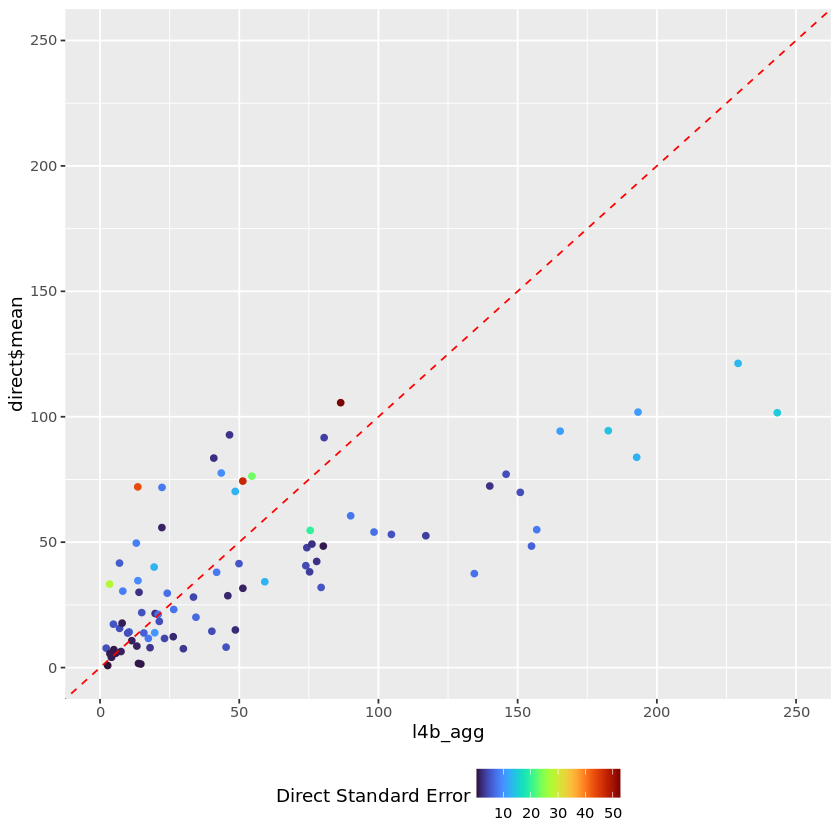

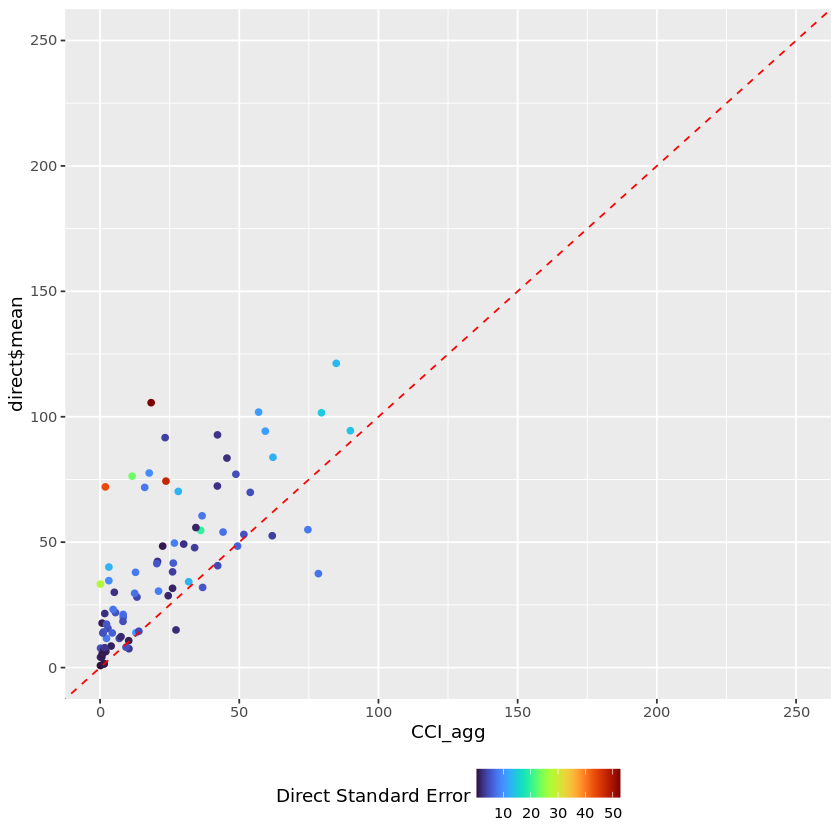

In [9]:
ggplot() + geom_point(aes(x = l4b_agg, y = direct$mean, col = direct$sd)) +
  scale_color_viridis(option = "turbo") +
  labs(col = "Direct Standard Error") +
  theme(legend.position = "bottom") + xlim(0,250) + ylim(0,250) +
  geom_abline(slope = 1, intercept = 0, color = 'red', linetype = 'dashed')

ggplot() + geom_point(aes(x = CCI_agg, y = direct$mean, col = direct$sd)) +
  scale_color_viridis(option = "turbo") +
  labs(col = "Direct Standard Error") +
  theme(legend.position = "bottom") + xlim(0,250) + ylim(0,250) +
  geom_abline(slope = 1, intercept = 0, color = 'red', linetype = 'dashed')

Are these plots in short tons per acre? Scaling aside, the relationship is not that great...
Regardless, we'll carry on! 

The BYM spatial effects require an "graph" telling it what's connected to what. For a final model, I don't think this will be the best choice. For one, I do not trust the behavior of the BYM process for the islands off the coast that have no graph-relationship. Second, it considers two regions sharing a 500 km border to have the same relationship as two regions that barely touch. But it will suffice for the demonstration, and we can play around with other spatial models in time.

The graph is communicated to the model with an adjacency matrix. Within this matrix,entry (i,j) is positive if area i and j are adjacent. The rows are standardized so that the sum of each row is equal to 1.

Package 'spdep' gives an elegant (but for some reason quite slow) way of constructing this adjacency matrix

NEHA COMMENTS/QUESTIONS: 

(1) No, the values are in tons per hectare. Unfortunately, as you can see, the GEDI estimates are very different from the Mexican NFI (but the CCI estimates are better...?). Laura's group is working on imporving Mexcio's GEDI L4A estimates, so this will improve in the future. 

(2) From the online INLA book you shared (\url{https://becarioprecario.bitbucket.io/inla-gitbook/ch-spatial.html}), I understand how and why you created this "graph". Could we "project" this graph on the map of Mexico to see how it looks?

In [10]:
nbmat = units.shp %>% 
  poly2nb() %>%
  nb2mat(zero.policy = T) # zero.policy = T simply instructs the function not to freak out about the islands having no neighbors

Warning message:
“st_centroid assumes attributes are constant over geometries”


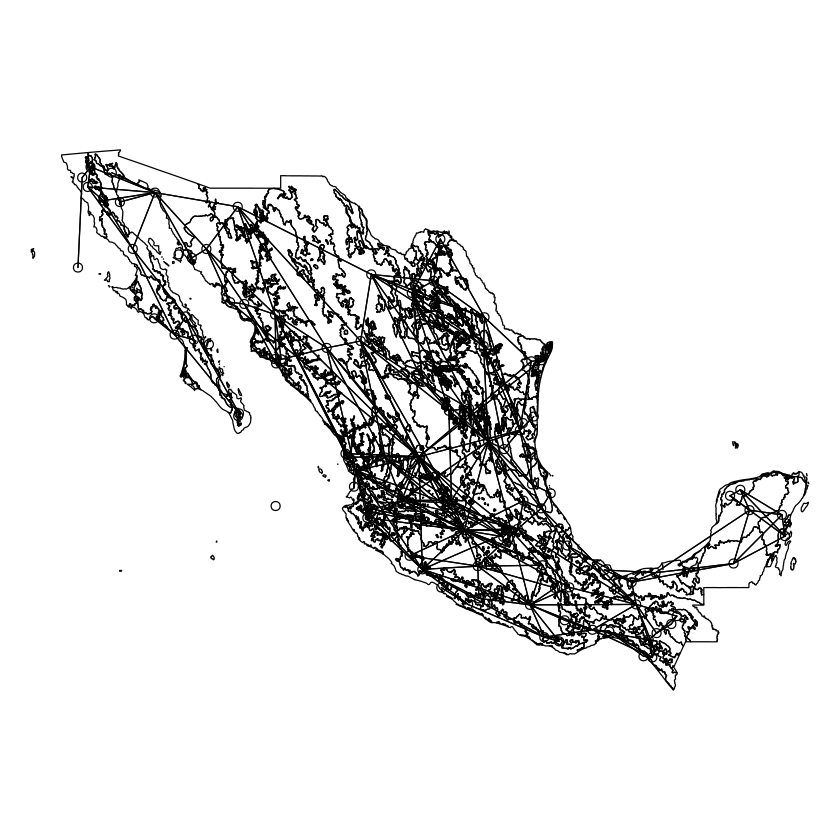

In [11]:
##### Just trying to visualize the above #########
par(mai = c(0, 0, 0, 0))
plot(st_geometry(units.shp))
centers = units.shp %>% st_centroid() %>% st_coordinates
poly_to_nb = poly2nb(units.shp)
plot(poly_to_nb, centers, add = TRUE)

Here's an ugly (but fast) way of manually doing this same thing.

In [12]:
nbmat2 = st_intersects(units.shp, sparse = F)*1
nbmat2[cbind(1:nu,1:nu)] = 0
nbmat2 = diag(x = 1/rowSums(nbmat2))%*%nbmat2
nbmat2[is.na(nbmat2)] = 0

Plot them to show that they are the same.

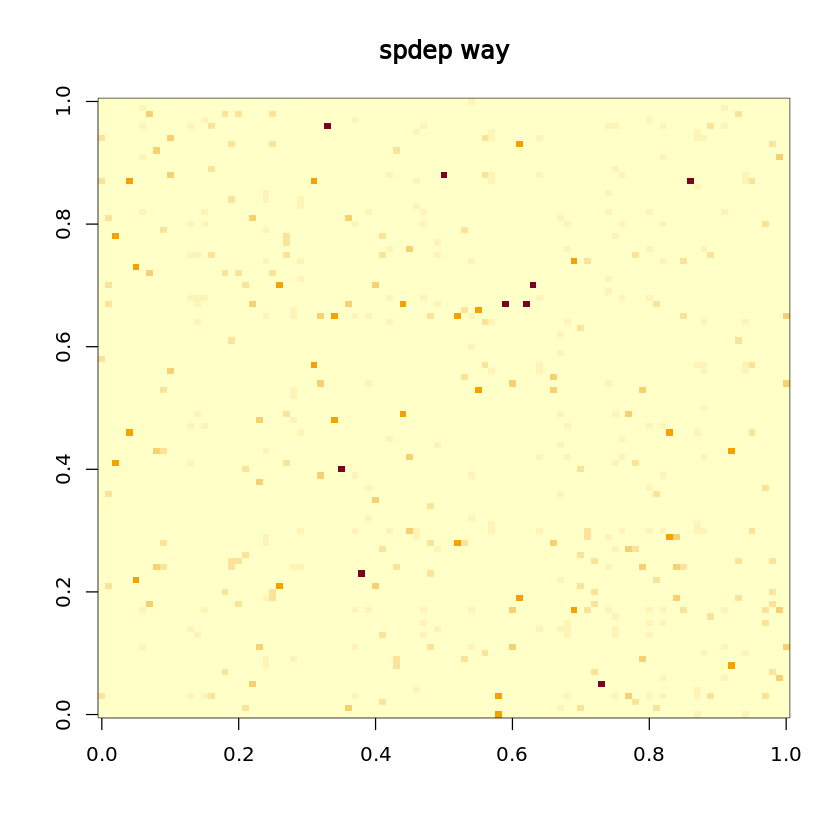

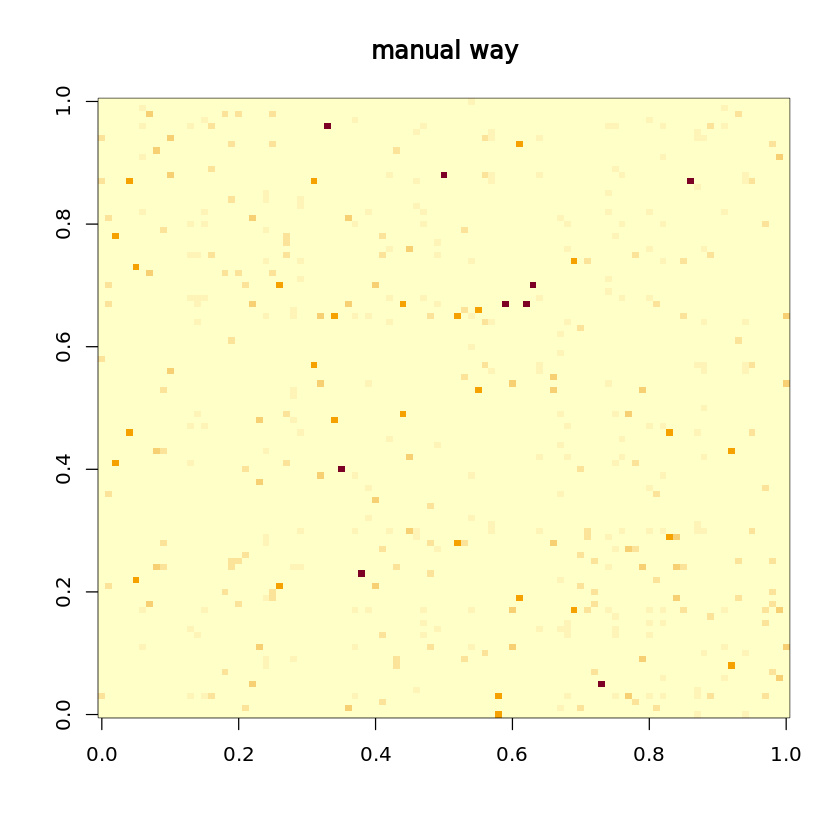

In [13]:
############ MATRIX OF NUMBER OF MUs TIMES NUMBER OF MUs #############
image(nbmat, main = 'spdep way')
image(nbmat2, main = 'manual way')
rm(nbmat2) # Remove one, cuz we don't need two ;)

Okay, now we begin the actual model construction. Working with INLA takes a bit of practice, but once it makes sense, it makes sense...

We'll soon define our model formula. But first, we need to tell INLA that the sampling error variances are assumed to be known and fixed. This next step might seem odd at first, but it is the only way I know to do this within INLA.
We're going to fix the sampling error to have a standard normal distribution $N(0,1)$. Within the "stack" (covered soon), these variables will be multiplied by the direct estimate standard errors, $\hat{\sigma}_i$, so that the resulting variable has distribution $N(0, \hat{\sigma}_i^2)$.

In [15]:
samp.error.prior = list(prec = list(initial = 0,fixed = TRUE)) 

The variance is on the log-scale, so the line `initial = 0` tells it the variance should be $\exp(0) = 1$. The `fixed = TRUE` line tells INLA that this value is known and should be fixed: otherwise, INLA would simply use this as a starting value.

Okay, let's define our model formula now.

In [16]:
formula = direct.estimate ~ # The direct estimate is equal to...
  -1 + intercept + # ... the intercept (the -1 removes the automatic intercept)
  l4b + # ...plus a regression on the l4b
  CCI + # ...plus a regression on CCI
  f(spatial.alpha, model = 'bym2', graph = nbmat, scale.model = T) + #... plus a bym for the spatial alpha
  f(spatial.beta1, model = 'bym2', graph = nbmat, scale.model = T) + #... plus a bym for the spatial beta
  f(spatial.beta2, model = 'bym2', graph = nbmat, scale.model = T) + #... plus a bym for the spatial beta
  f(samp.error, model = 'iid', hyper = samp.error.prior) # ...plus the sampling error from the direct estimate. Note that we feed it 'hyper = samp.error.prior'.

Here is (what I think) is the trickest part of mastering INLA: the data stack.
The stack is composed of 

* `data = list(...)`. This is where the model response(s) go. This is a univariate model with just AGBD, so will be just a list of one item here 

* `A = list(...)`. This is the list of "design matrices". These are the quantities that are multiplied by the model effects. For instance, $\tilde{\beta}_i$ in (1) needs to be multiplied by the L4B value. These need to be in the corresponding order of the `effects`, considered next.

* `effects` = list(...)`. These are all the unknown effects in your model. These need to share the same name that you specified in your formula before.

In [17]:
stack = inla.stack(
  data = list(direct.estimate = direct$mean),
  A = list(1, # We don't need to multiply anything extra onto the intercept...
           1, # ... or the L4B regression
           1, #... or the CCI regression 
           1, # ... or the spatial alpha, so we just put 1's here
           Diagonal(x = l4b_agg), # But spatial beta needs to be multiplied by the l4b values
           Diagonal(x = CCI_agg), # But spatial beta needs to be multiplied by the CCI values
           Diagonal(x = direct$sd)), # And the sampling error by the direct estimate standard deviations.
  effects = list(intercept = rep(1,nu), 
                 l4b = l4b_agg,
                 CCI = CCI_agg,
                 spatial.alpha = 1:nu, # The random effects just need to given unique indices.
                 spatial.beta1 = 1:nu,
                 spatial.beta2 = 1:nu,
                 samp.error = 1:nu))

Cool, now we are ready to fit the model. This will be pretty fast, as far as Bayesian random effects models go. The line `control.compute = list()` takes optional quantities to compute: this line could be deleted and the code would still run. Option `config = T` computes and saves certain internals so we can draw posterior samples later (we usually want to do this). Option `dic` and `waic` are model fit scores, where a model with a lower number fits the data better. Gives a quick and dirty way to compare models.

In [18]:
model_fit = inla(formula = formula, # Provide the formula
                 family = 'gaussian', # We assume our data follows a Gaussian generalized linear model (GLM)
                 data = inla.stack.data(stack), # These line and the one below are simply how we feed INLA the stack.
                 control.predictor = list(A = inla.stack.A(stack)),
                 control.compute = list(config = T, dic = T, waic = T)) # See discussion above on this line.

Warning message in inla.model.properties.generic(inla.trim.family(model), mm[names(mm) == :
“Model 'bym2' in section 'latent' is marked as 'experimental'; changes may appear at any time.
  Use this model with extra care!!! Further warnings are disabled.”


Great! We can print a terse model summary:

In [19]:
summary(model_fit)


Call:
   c("inla.core(formula = formula, family = family, contrasts = contrasts, 
   ", " data = data, quantiles = quantiles, E = E, offset = offset, ", " 
   scale = scale, weights = weights, Ntrials = Ntrials, strata = strata, 
   ", " lp.scale = lp.scale, link.covariates = link.covariates, verbose = 
   verbose, ", " lincomb = lincomb, selection = selection, control.compute 
   = control.compute, ", " control.predictor = control.predictor, 
   control.family = control.family, ", " control.inla = control.inla, 
   control.fixed = control.fixed, ", " control.mode = control.mode, 
   control.expert = control.expert, ", " control.hazard = control.hazard, 
   control.lincomb = control.lincomb, ", " control.update = 
   control.update, control.lp.scale = control.lp.scale, ", " 
   control.pardiso = control.pardiso, only.hyperparam = only.hyperparam, 
   ", " inla.call = inla.call, inla.arg = inla.arg, num.threads = 
   num.threads, ", " keep = keep, working.directory = working.directory,

Now we can draw posterior samples, which is how we often make inference in Bayesian statistics. We draw draw "raw" samples from our model using `inla.posterior.sample()`. We then write a function expressing the quantity we are interested in as a function of our model parameters/effects. Then we use  `inla.posterior.sample.eval()` to get samples for that quantity.

In [20]:
samples = inla.posterior.sample(n = 5000, # Draw 5000 samples...
                                result = model_fit # ...from this model
                                )

We would the true biomass for each of the MU's, so we'll draw posterior samples according to equation (2). Here is our function, which we then use to draw samples from.

In [21]:
eval.function = function(...){intercept + l4b*l4b_agg + CCI*CCI_agg + spatial.alpha[1:nu] + spatial.beta1[1:nu]*l4b_agg  + spatial.beta2[1:nu]*CCI_agg}
predict.samples = inla.posterior.sample.eval(fun = eval.function,samples = samples)

This (empirically) gives us the posterior distribution for the biomass for the MU's. The $i$th row gives 1000 posterior samples for the $i$th MU. For example,

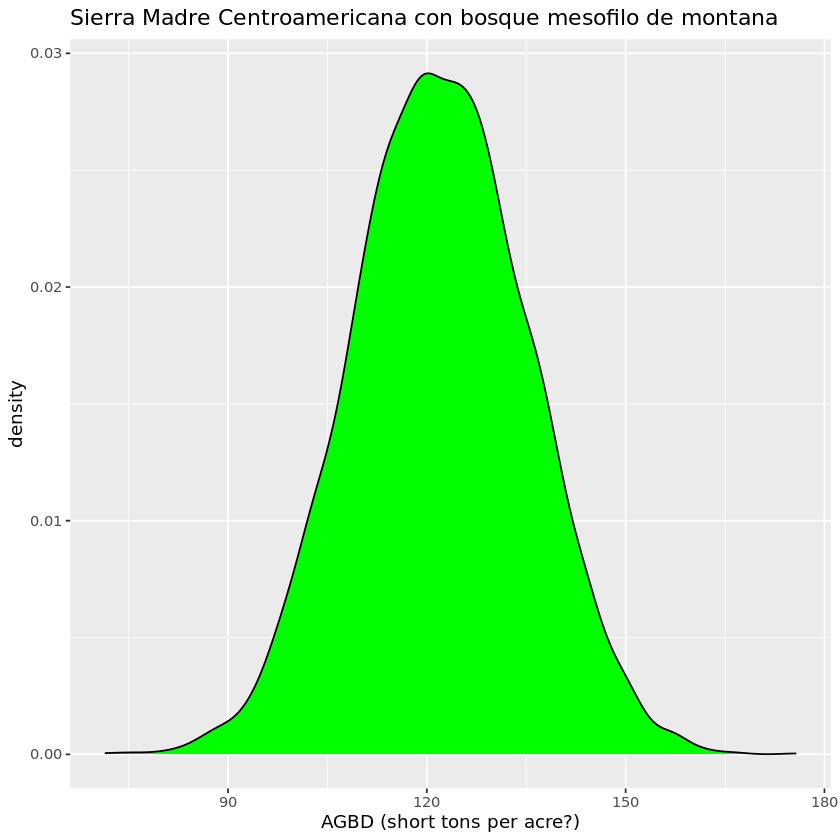

In [22]:
ggplot() + geom_density(aes(x = predict.samples[80,]), fill = "green") +
  xlab("AGBD (short tons per acre?)") +
  ggtitle(units.shp$DESECON4[80])

Once we have the samples, everything else is easy. Here is the posterior expected value and standard deviation for our MU AGBD.

Warning message:
“Removed 19 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 19 rows containing missing values (`geom_point()`).”


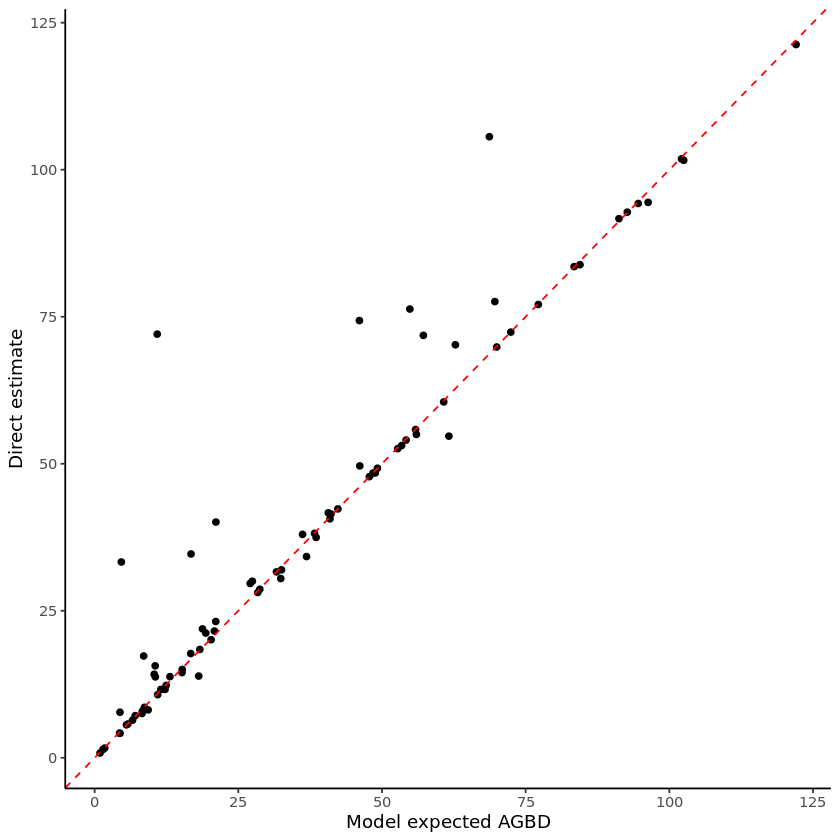

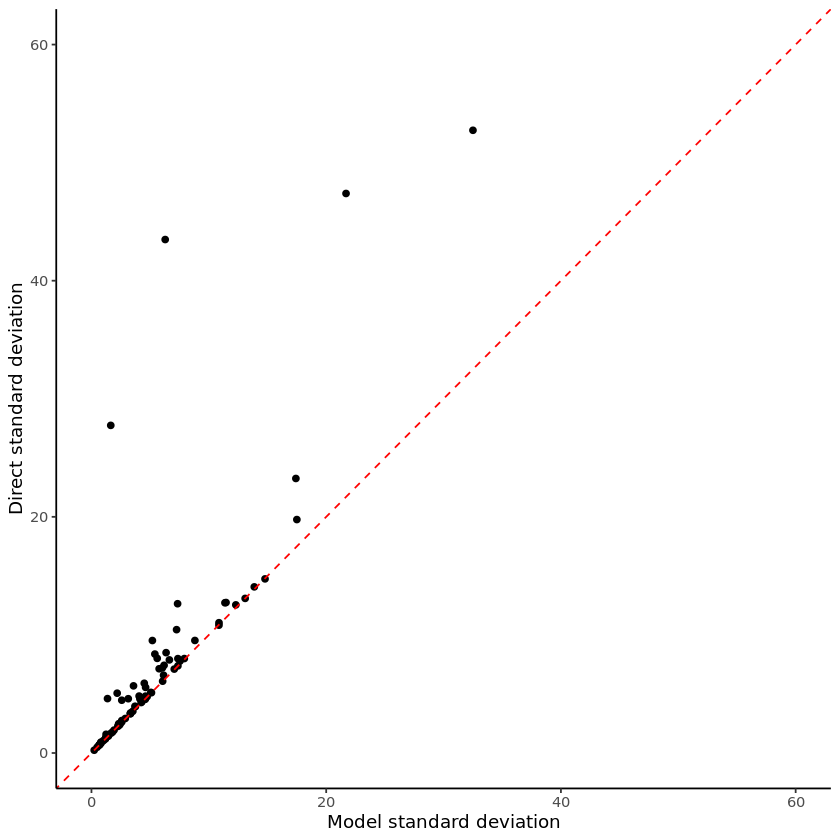

In [23]:
agbd.mu = rowMeans(predict.samples)
agbd.sd = apply(predict.samples, 1, sd)

ggplot() + geom_point(aes(x = agbd.mu, y = direct$mean)) +
  xlab("Model expected AGBD") + ylab("Direct estimate") +
  geom_abline(slope = 1, intercept = 0, color = 'red', linetype = 'dashed')+ theme_bw() +
theme(
    plot.background = element_blank(),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
    panel.border = element_blank(),
    axis.line = element_line(color = 'black')
  )

ggplot() + geom_point(aes(x = agbd.sd, y = direct$sd)) +
  xlab("Model standard deviation") + ylab("Direct standard deviation") +
  geom_abline(slope = 1, intercept = 0, color = 'red', linetype = 'dashed') + ylim(0,60)  + xlim(0,60) + theme_bw() +
theme(
    plot.background = element_blank(),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
    panel.border = element_blank(),
    axis.line = element_line(color = 'black')
  )

We get some modest improvements in precision, but I expected better. We do, however, get estimates in MU's where there are no plots.

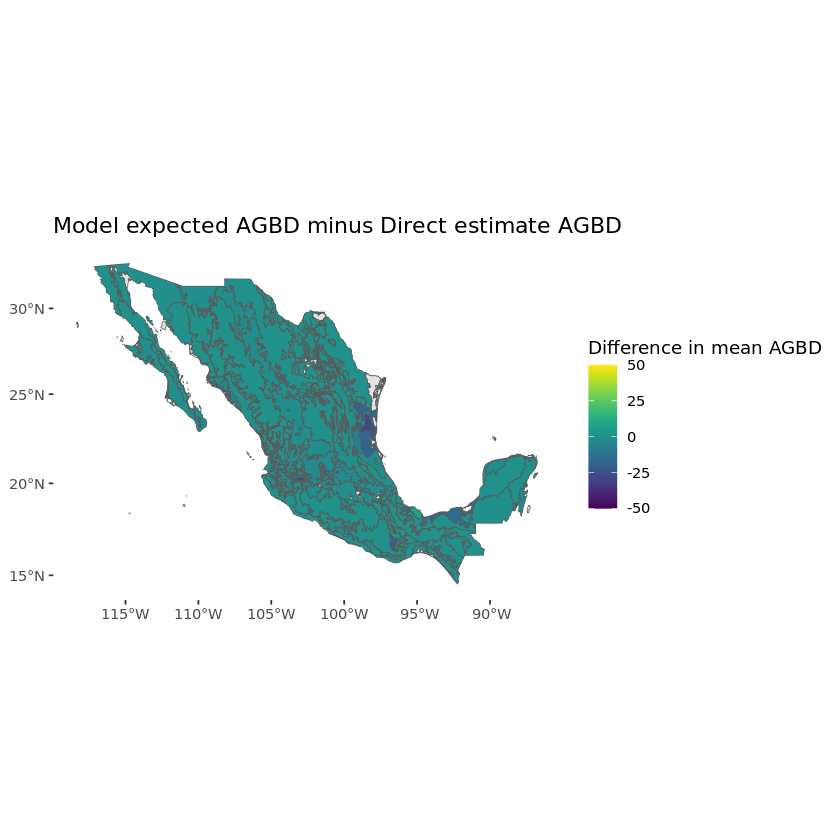

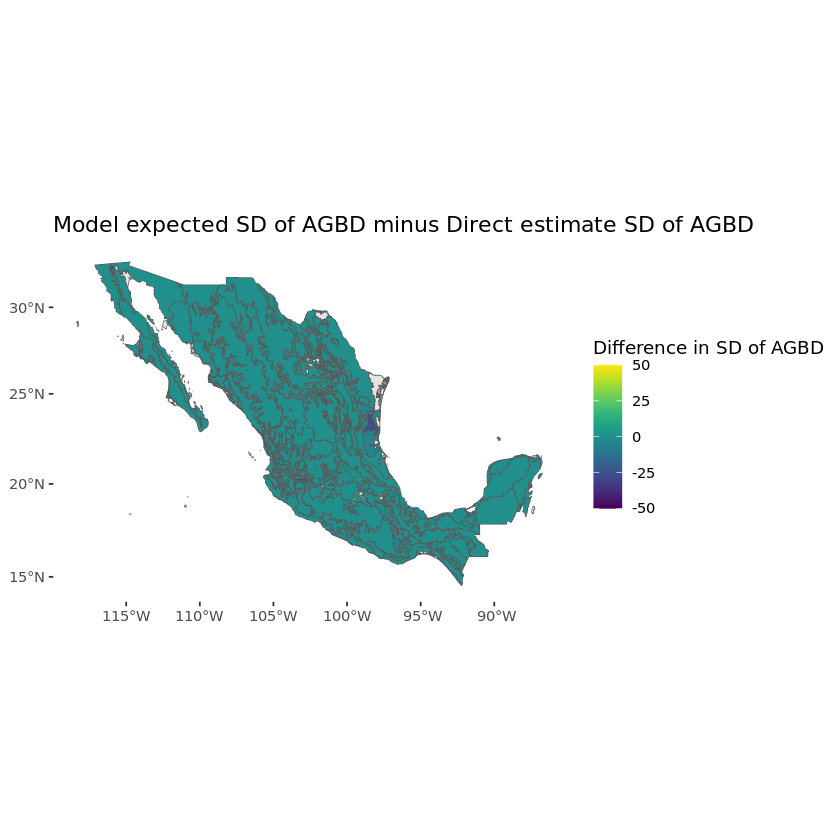

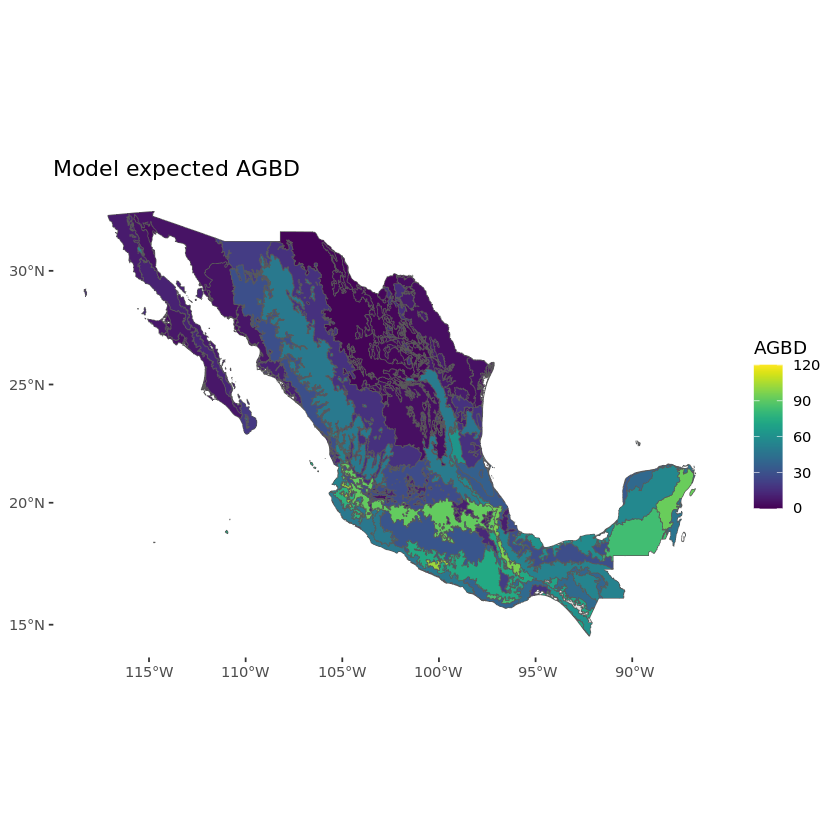

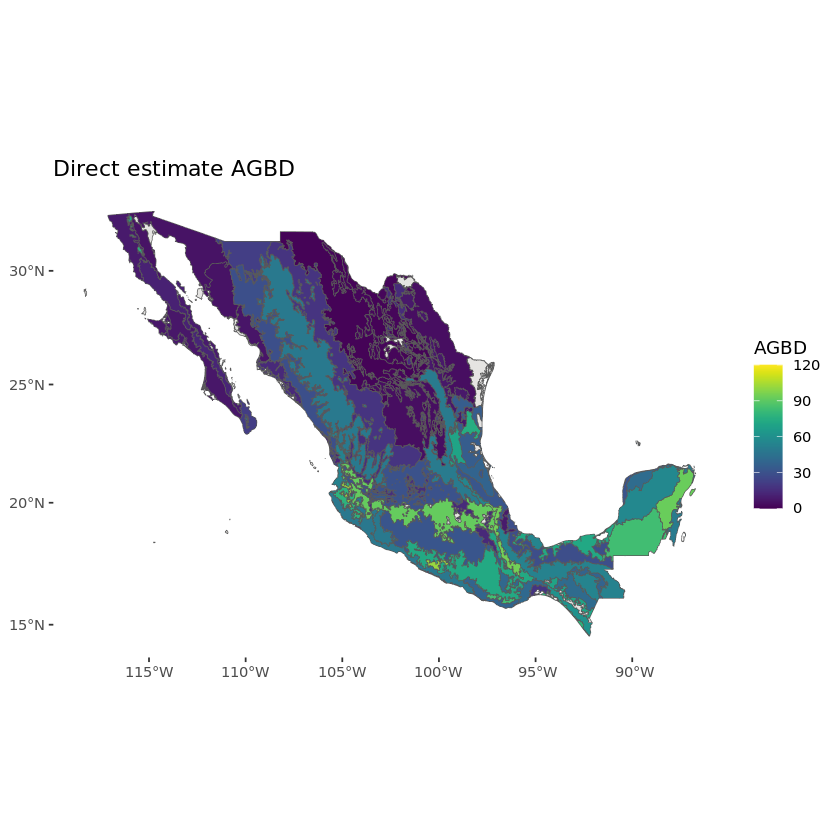

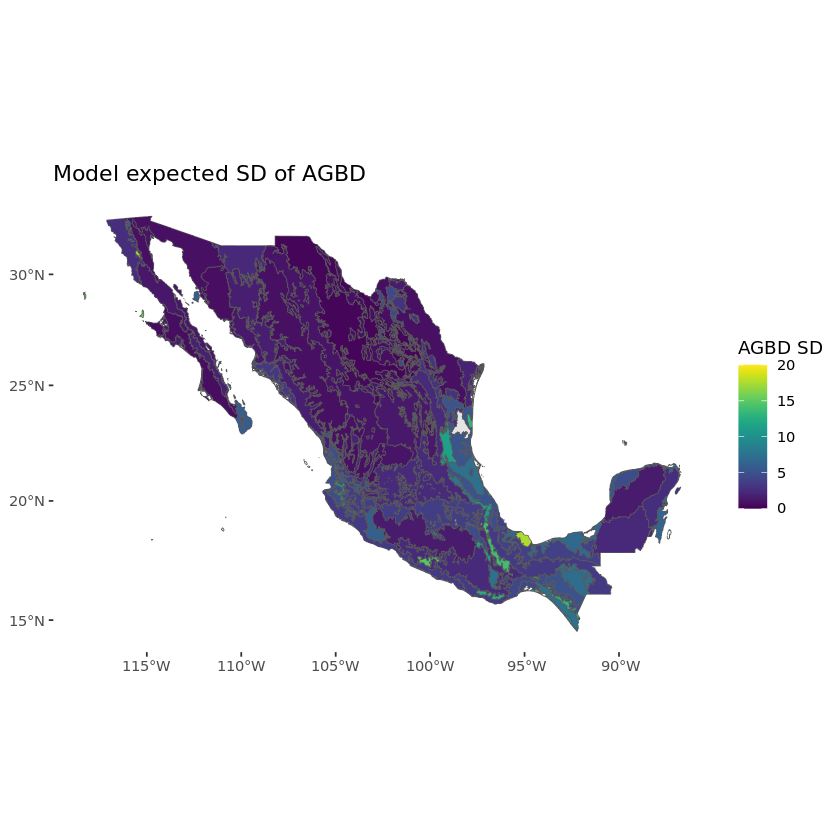

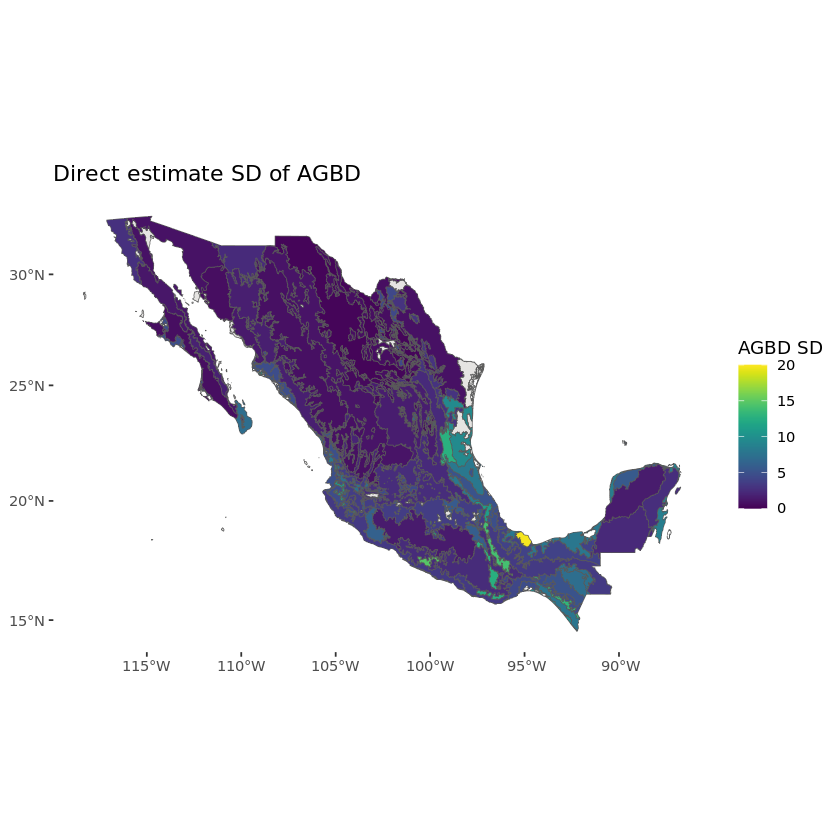

In [24]:
ggplot() + geom_sf(data = units.shp, aes(fill = (agbd.mu - direct$mean))) +
  scale_fill_viridis(limits = c(-50,50),na.value="#E5E4E2") + 
  labs(fill = "Difference in mean AGBD") +
  ggtitle("Model expected AGBD minus Direct estimate AGBD") + 
  theme(
        panel.grid.major = element_blank(), 
        panel.grid.minor = element_blank(),
        panel.background = element_blank()
   )

ggplot() + geom_sf(data = units.shp, aes(fill = (agbd.sd - direct$sd))) +
  scale_fill_viridis(limits = c(-50,50),na.value="#E5E4E2") + 
  labs(fill = "Difference in SD of AGBD") +
  ggtitle("Model expected SD of AGBD minus Direct estimate SD of AGBD") + 
  theme(
        panel.grid.major = element_blank(), 
        panel.grid.minor = element_blank(),
        panel.background = element_blank()
   )

ggplot() + geom_sf(data = units.shp, aes(fill = agbd.mu)) +
  scale_fill_viridis(limits = c(0,120),na.value="#E5E4E2") + 
  labs(fill = "AGBD") +
  ggtitle("Model expected AGBD") + 
  theme(
        panel.grid.major = element_blank(), 
        panel.grid.minor = element_blank(),
        panel.background = element_blank()
   )

ggplot() + geom_sf(data = units.shp, aes(fill = direct$mean)) +
  scale_fill_viridis(limits = c(0,120),na.value="#E5E4E2") + 
  labs(fill = "AGBD") +
  ggtitle("Direct estimate AGBD") + 
  theme(
        panel.grid.major = element_blank(), 
        panel.grid.minor = element_blank(),
        panel.background = element_blank()
   )

ggplot() + geom_sf(data = units.shp, aes(fill = agbd.sd)) +
  scale_fill_viridis(limits = c(0,20),na.value="#E5E4E2") + 
  labs(fill = "AGBD SD") +
  ggtitle("Model expected SD of AGBD") + 
  theme(
        panel.grid.major = element_blank(), 
        panel.grid.minor = element_blank(),
        panel.background = element_blank()
   )

ggplot() + geom_sf(data = units.shp, aes(fill = direct$sd)) +
  scale_fill_viridis(limits = c(0,20),na.value="#E5E4E2") + 
  labs(fill = "AGBD SD") +
  ggtitle("Direct estimate SD of AGBD") + 
  theme(
        panel.grid.major = element_blank(), 
        panel.grid.minor = element_blank(),
        panel.background = element_blank()
   )

A little hard to see, but there are some gray gaps in the direct estimate map, but none in the model map.

We can also examine the effect of the spatial effects. We'll draw samples for those alone.

NEHA QUESTION: And what exactly do these "spatial effects" show?

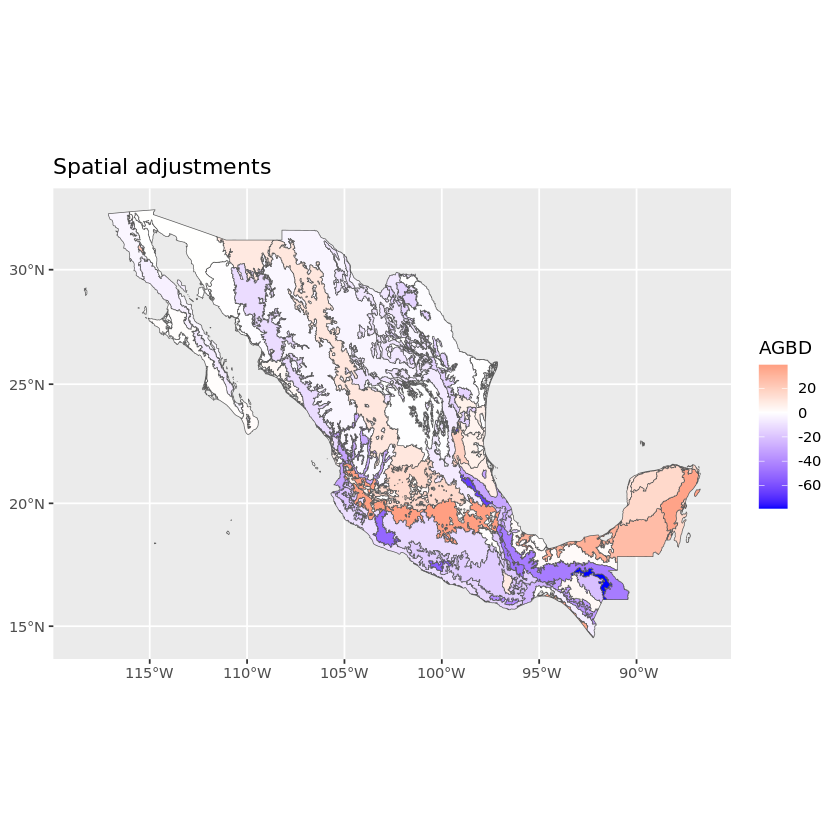

In [25]:
##### THIS SHOWS YOU WHAT EFFECT THE BETA-TILDE SPATIALLY VARYING SLOPE HAS ON THE RESULTS ###########

spatial.function = function(...){
  spatial.alpha[1:nu] + spatial.beta1[1:nu]*l4b_agg + spatial.beta2[1:nu]*CCI_agg
}

spatial.samps = inla.posterior.sample.eval(fun = spatial.function,samples = samples)

spatial.mu = rowMeans(spatial.samps)

ggplot() + geom_sf(data = units.shp, aes(fill = spatial.mu)) +
  scale_fill_gradient2(low = "blue", high = "red") + 
  labs(fill = "AGBD") +
  ggtitle("Spatial adjustments")

Pretty cool!

Just to give an example of another sort of spatial model we can fit, instead of the spatial correlation of $\tilde{\alpha}_i, \tilde{\beta}_i$ being assessed by neighboring, we can assess it by the distance between the centroids of the MU's with a Mat\'ern Gaussian process. Here's our new function.

In [34]:
centers = units.shp %>% st_centroid() %>% st_coordinates
formula2 = direct.estimate ~ 
  -1 + intercept +
  l4b + 
  CCI + 
  f(spatial.alpha, model = 'dmatern', locations = centers) + # Notice we replace bym
  f(spatial.beta1, model = 'dmatern', locations = centers) + # here too
  f(spatial.beta2, model = 'dmatern', locations = centers) + # here too
  f(samp.error, model = 'iid', hyper = samp.error.prior)

model_fit2 = inla(formula = formula2,
                  family = 'gaussian',
                  data = inla.stack.data(stack),
                  control.predictor = list(A = inla.stack.A(stack)),
                  control.compute = list(config = T, dic = T, waic = T))

Warning message:
“st_centroid assumes attributes are constant over geometries”


Error in inla.inlaprogram.has.crashed() : 
  The inla-program exited with an error. Unless you interupted it yourself, please rerun with verbose=TRUE and check the output carefully.
  If this does not help, please contact the developers at <help@r-inla.org>.

 *** inla.core.safe:  inla.program has crashed: rerun to get better initial values. try=1/1 
Error in inla.inlaprogram.has.crashed() : 
  The inla-program exited with an error. Unless you interupted it yourself, please rerun with verbose=TRUE and check the output carefully.
  If this does not help, please contact the developers at <help@r-inla.org>.


ERROR: Error in inla.core.safe(formula = formula, family = family, contrasts = contrasts, : *** Failed to get good enough initial values. Maybe it is due to something else.


We can compare the WAIC and DIC scores from the previous model to see if there are any improvements (lower is better).

WIAC:

In [27]:
model_fit$waic$waic
model_fit2$waic$waic

[1] -497.1764

[1] 9289.057

DIC:

In [28]:
model_fit$dic$dic
model_fit2$dic$dic

[1] -472.5343

[1] NA

Not really any substantial differences in these scores. Let's look at the new predictions.

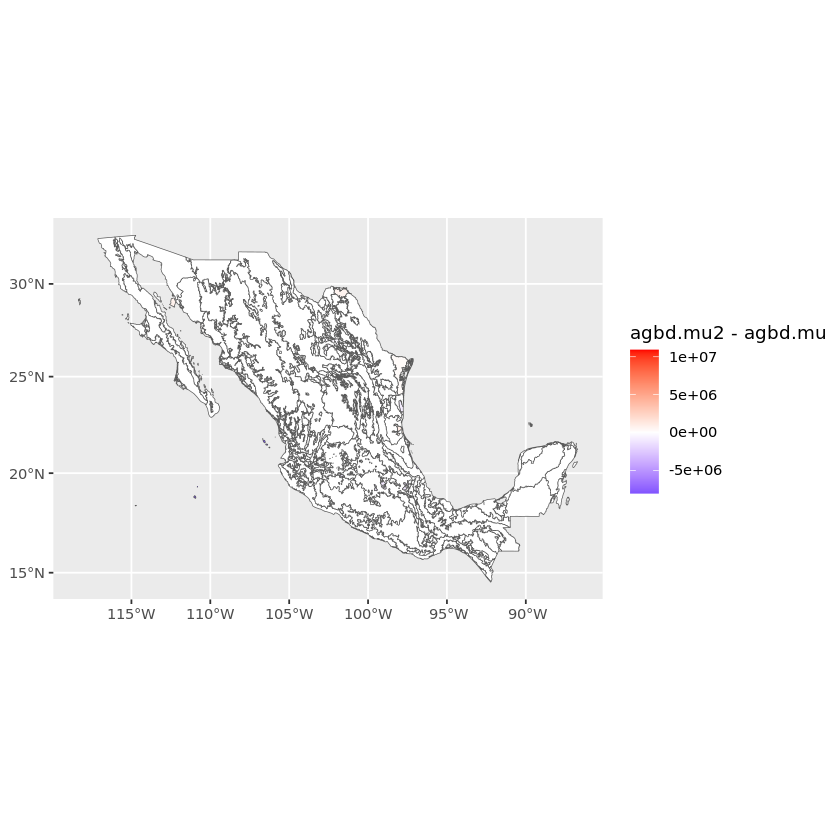

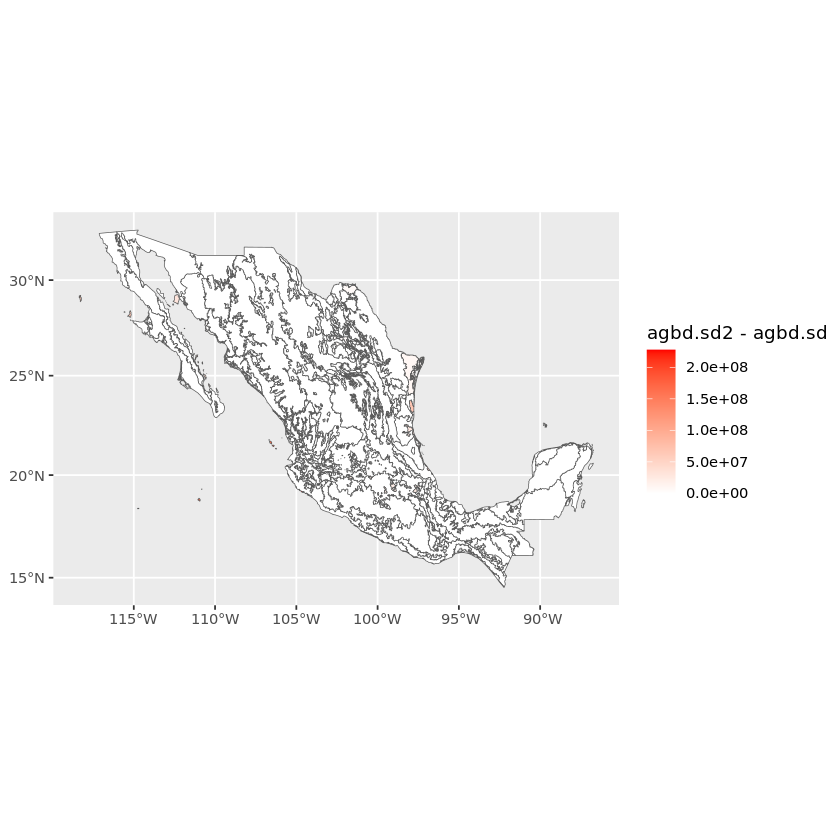

In [29]:
posterior.samples2 = inla.posterior.sample(n = 1000, result = model_fit2)
predict.samples2 = inla.posterior.sample.eval(fun = eval.function,samples = posterior.samples2)

agbd.mu2 = rowMeans(predict.samples2)
agbd.sd2 = apply(predict.samples2, 1, sd)

ggplot() + geom_sf(data = units.shp, aes(fill = agbd.mu2 - agbd.mu)) +
  scale_fill_gradient2(low = "blue", high = "red")

ggplot() + geom_sf(data = units.shp, aes(fill = agbd.sd2 - agbd.sd)) +
  scale_fill_gradient2(low = "blue", high = "red")

Only substantial differences for a couple MU's. Interesting!